In [93]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, random
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import re, urllib

utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
FILE_BASE_DIR="/home/nathan/reddit_archive/"
sys.path.append(BASE_DIR)
subreddit_id = "2qh13"

ARCHIVE_DIR = "/home/nathan/reddit_archive/03.2017"

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
from app.models import Base, SubredditPage, FrontPage, Subreddit, Post, ModAction, Experiment
from utils.common import PageType

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

# Sample Recent r/feminism newcomer commenters

### Data integrity checks and load background data

In [ ]:
## LOOK AT HOW RECENT OUR COMMENTS DATASET IS (HOPE THAT WE HAVE ALL THE WAY TO THE BEGINNING OF MARCH)
## LOOK AT HOW RECENT OUR SUBMISSIONS DATASET IS (HOPE THAT WE HAVE ALL THE WAY TO THE BEGINNING OF MARCH)

## CONSTRUCT A MEASURE OF THE SIX MONTH WINDOW (FROM Feminism Newcomer Analysis)

In [64]:
query_text = """
select * from comments 
    WHERE subreddit_id = '2qr7i'
    AND created_at >= '2018-03-01'
    ORDER BY created_utc ASC;
"""

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

database_comments = []

for row in db_engine.execute(text(query_text)):
    comment = {}
    comment_data = json.loads(row['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    for key in row.keys():
        comment[key]=row[key]
    comment['created'] = comment['created_utc']
    database_comments.append(comment)
    
print("Loaded {0} Comments".format(len(database_comments)))

Loaded 6642 Comments


In [65]:
file_comments = []
comment_ids = set()
comment_count = 0

comments_filename="full_feminism_comments_through_02_2018.json"

with open(os.path.join(FILE_BASE_DIR, "selected_output", comments_filename), "r") as f:
    for line in f:
        item = json.loads(line)
        if(item['id'] not in comment_ids):
            item['created'] = datetime.datetime.utcfromtimestamp(float(item['created_utc']))
            item['body.charlength'] = len(item['body'])
            #item['body'] = None
            file_comments.append(item)
            comment_ids.add(item['id'])
        comment_count += 1
#file_comments = sorted(file_comments, key = lambda x: x['created'])        

print("Loaded {0} Comments".format(len(all_comments)))
print("Loaded {0} Comment lines".format(comment_count))

Loaded 91906 Comments
Loaded 90555 Comment lines


### Add database comments to file-loaded comments

In [66]:
keys_to_include = []
for key in file_comments[0].keys():
    if key in database_comments[0].keys():
        keys_to_include.append(key)
print("Keys in file and in database: [{0}]".format((",").join(keys_to_skip)))


all_comments = file_comments

added_comment_ids = 0
duplicate_comment_ids = 0

for comment in database_comments:
    if comment['id'] not in comment_ids:
        trimmed_comment = {}
        for key in keys_to_include:
            trimmed_comment[key] = comment[key]
        all_comments.append(trimmed_comment)
        comment_ids.add(comment['id'])
        added_comment_ids += 1
    else:
        duplicate_comment_ids += 1
print("Merged comment datasets. Added {0} comments and skipped {1} duplicates".format(
    added_comment_ids, duplicate_comment_ids))

## NOW SORT COMMENTS
all_comments = sorted(all_comments, key = lambda x: x['created'])        

Keys in file and in database: [retrieved_on,body.charlength]
Merged comment datasets. Added 6494 comments and skipped 148 duplicates


### Record the number of previous comments that a participant made in the prior six months

In [ ]:
def previous_actions():
    return {"comments":[], "posts":[]}

author_records = defaultdict(previous_actions)

for item in all_comments:
    author_id = item['author']
    author_records[author_id]['comments'].append(item)

#one_eighty_days in seconds
def count_if_eligible(current, comparator):
    one_eighty_days = 60*60*24*180
    if(current['created'] > comparator['created'] and 
       (current['created'] - comparator['created']).total_seconds()<one_eighty_days):
        return 1
    return 0

earliest_date = all_comments[0]['created']

sys.stdout.write("\ncomments")
sys.stdout.flush()
items_processed = 0
for item in all_comments:
    previous_comments = 0
    for comment in author_records[item['author']]['comments']:
        if(item['created'] > comment['created']):
            previous_comments += count_if_eligible(item, comment) 
    items_processed += 1
    item['previous.comments'] = previous_comments
    item['eligible'] = item['created'] > earliest_date
    
    if(items_processed % 1000 == 0):
        sys.stdout.write(".")
        sys.stdout.flush()
    


comments..........................................................................................

# Create a Sample of Recent Commenters 
First time commenters within the last 45 days

In [77]:
recent_comment_in_seconds = 60*60*24*45
current_time = datetime.datetime.utcnow()

In [80]:
eligible_comments = [x for x in all_comments if x['eligible'] and 
                      (current_time - x['created']).total_seconds() < recent_comment_in_seconds and
                      x['previous.comments']==0]

print("Total comments: {0}. Eligible comments: {1}".format(
    len(all_comments),
    len(eligible_comments)))

Total comments: 91906. Eligible comments: 1652


### Label comments by how many weeks previously they commented for the first time (for a stratified random sample)

In [82]:
one_week_in_seconds = 60*60*24*7

for comment in eligible_comments:
    comment['first.comment.week.diff'] = int((current_time - comment['created']).total_seconds() / 
                                             one_week_in_seconds)
    
    
    

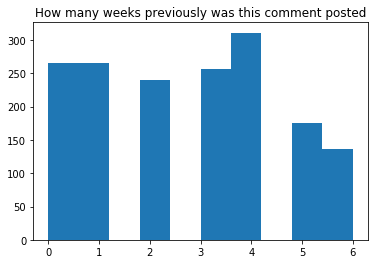

In [84]:
plt.hist([comment['first.comment.week.diff'] for comment in eligible_comments])
plt.title("How many weeks previously was this comment posted")
plt.show()

### Create a stratified random sample of accounts to message, based on the elapsed number of weeks since they originally posted their first comment
Later, we may want to do a post-hoc analysis of how many comments they had previously made in the subreddit. Note that we will want to include them int he sample even if their account doesn't exist, because we're going to be including those kinds of accounts in the study, and we will want to think about that attrition as an expected part of the sample.

In [88]:
eligible_by_week = {}
for key in set([x['first.comment.week.diff'] for x in eligible_comments]):
    eligible_by_week[key] = [x['author'] for x in eligible_comments if 
                             x['first.comment.week.diff'] == key]

In [90]:
for key in sorted(eligible_by_week.keys()):
    print("Week age {0}: {1} authors ".format(key, len(eligible_by_week[key])))

Week age 0: 266 authors 
Week age 1: 265 authors 
Week age 2: 240 authors 
Week age 3: 257 authors 
Week age 4: 311 authors 
Week age 5: 176 authors 
Week age 6: 137 authors 


In [101]:
##  Decision: survey 200 authors per group
##  Only survey the last 4 weeks
random.seed(880442) # current milliseconds at code time
sample_size = 200
selected_by_week = {}
for week in sorted(eligible_by_week.keys()):
    if week <=4:
        selected_by_week[week] = random.sample(eligible_by_week[week], sample_size)
        
for week in sorted(selected_by_week.keys()):
    print("Week age {0}: {1} authors ".format(week, len(selected_by_week[week])))

Week age 0: 200 authors 
Week age 1: 200 authors 
Week age 2: 200 authors 
Week age 3: 200 authors 
Week age 4: 200 authors 


# Construct and personalize the message

# Send the message

False

In [ ]:
#r.send_message('user', 'Subject Line', 'You are awesome!')